In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Forecasting with Recurrent Neural Network (Sequence to Vector)
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# Dataset for machine learning.
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  # Create a dataset of tensors.
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Drop remaining values so we get same size.
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # The dataset contains a tensor with size of 5.
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Split into two arrays, one for inputs and one for labels.
  dataset = dataset.map(lambda window: (window[ : -1], window[-1 : ]))

  # Shuffle the dataset.
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches. The 'prefetch' indicates the Tensorflow will
  # fetch the data while working, so we always have data to use.
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

# Predict function.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

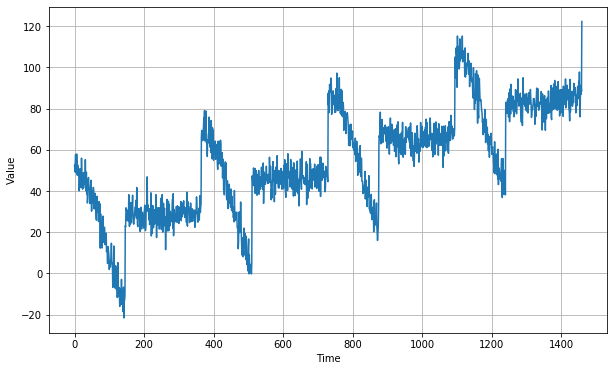

In [4]:
# Create dataset.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Prepare for machine learning.
split_time    = 1000
time_train    = time[:split_time]
series_train  = series[:split_time]
time_valid    = time[split_time:]
series_valid  = series[split_time:]

In [6]:
# ==================
# RNN Forecasting (Sequence to Vector)
# ==================
# Clear session, just useful under development, as we usually
# run the session multiple time in the notebook.
SEED        = 42
WINDOW_SIZE = 30
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE, batch_size = 128)

# Build the RNN model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.SimpleRNN(100, return_sequences = True),
  tf.keras.layers.SimpleRNN(100),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20)
)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9),
  metrics = ["mae"]
)
history = model.fit(dataset_train, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 383ms/step - loss: 49.6374 - mae: 50.8966
Epoch 2/100
8/8 [==============================] - 0s 61ms/step - loss: 22.8817 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 0s 53ms/step - loss: 19.4102 - mae: 19.5125
Epoch 4/100
8/8 [==============================] - 0s 55ms/step - loss: 16.8363 - mae: 17.3121
Epoch 5/100
8/8 [==============================] - 0s 58ms/step - loss: 15.6861 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 0s 61ms/step - loss: 15.1294 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 0s 61ms/step - loss: 14.5319 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 0s 56ms/step - loss: 14.0056 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 0s 52ms/step - loss: 13.6949 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 0s 55ms/step - loss: 13.4131 - mae: 14.0410
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 30]

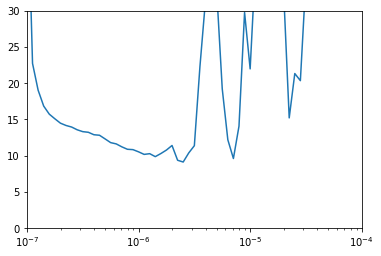

In [7]:
# Find the optimal learning rate.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [0]:
# As we see that it would be safe to start with 1e-6.

In [9]:
# Update model with the learning rate.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE, batch_size = 128)
dataset_valid = window_dataset(series_valid, WINDOW_SIZE, batch_size = 128)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.SimpleRNN(100, return_sequences = True),
  tf.keras.layers.SimpleRNN(100),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1.5e-6, momentum = 0.9),
  metrics = ["mae"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 50)

# Only save the model everytime the model improves on validation.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",
    save_best_only = True
)

model.fit(
  dataset_train,
  epochs = 500,
  validation_data = dataset_valid,
  callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/500
8/8 [==============================] - 2s 223ms/step - loss: 59.3020 - mae: 60.3561 - val_loss: 42.0142 - val_mae: 42.3809
Epoch 2/500
8/8 [==============================] - 1s 77ms/step - loss: 36.5803 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 75ms/step - loss: 23.6567 - mae: 24.0715 - val_loss: 12.7571 - val_mae: 13.0819
Epoch 4/500
8/8 [==============================] - 1s 77ms/step - loss: 16.7817 - mae: 17.6511 - val_loss: 21.4765 - val_mae: 22.3447
Epoch 5/500
8/8 [==============================] - 1s 69ms/step - loss: 13.7011 - mae: 14.3758 - val_loss: 10.0938 - val_mae: 10.6566
Epoch 6/500
8/8 [==============================] - 1s 81ms/step - loss: 11.4010 - mae: 12.0649 - val_loss: 11.5668 - val_mae: 12.0478
Epoch 7/500
8/8 [==============================] - 1s 83ms/step - loss: 11.0705 - mae: 11.4645 - val_loss: 8.4023 - val_mae: 8.9583
Epoch 8/500
8/8 [==============================] - 1s 76ms/step

In [0]:
# Get the best model.
model = tf.keras.models.load_model("my_checkpoint.h5")

In [0]:
# Forcast the model.
rnn_forecast = model_forecast(
    model,
    series[split_time - WINDOW_SIZE: - 1],
    WINDOW_SIZE
)[:, 0]

MAE: 5.414164


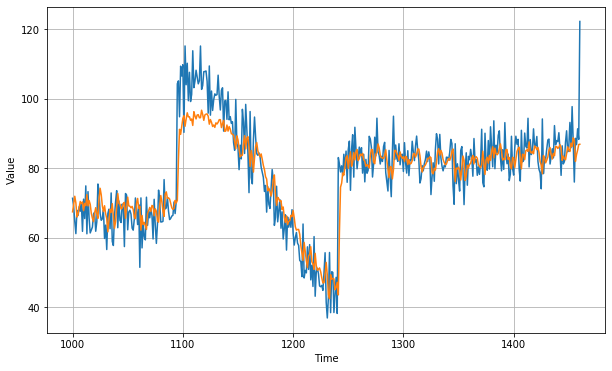

In [12]:
# Plot the forecast.
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

mae = tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()
print("MAE:", mae)